In [4]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import pyffx

In [5]:
class BlockTransform(nn.Module):
    """
    Generic class for block-wise transformation.
    """

    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size
        assert (
            config.height % self.block_size == 0 | config.width % self.block_size == 0
        ), "Image not divisible by block_size"
        self.blocks_axis0 = int(config.height / self.block_size)
        self.blocks_axis1 = int(config.width / self.block_size)

    def segment(self, X):
        """将输入张量 X 的维度重新排序，将通道维度从第二维移到最后一维。
        假设输入张量形状为 (batch_size, channels, height, width)，
        它将变为 (batch_size, height, width, channels)。"""
        X = X.permute(0, 2, 3, 1)
        '''将图像重新形状，分割为块。每个块的大小为 block_size x block_size，
        而图像被分割成 blocks_axis0 x blocks_axis1 个块。'''
        X = X.reshape(
            -1,
            self.blocks_axis0,
            self.block_size,
            self.blocks_axis1,
            self.block_size,
            1,
        )

        X = X.permute(0, 1, 3, 2, 4, 5)
        '''将这些块展平成一维向量，每个块现在被表示为一维的像素值序列。'''
        X = X.reshape(
            -1,
            self.blocks_axis0,
            self.blocks_axis1,
            self.block_size * self.block_size * 1,
        )
        return X

    def integrate(self, X):
        X = X.reshape(
            -1,
            self.blocks_axis0,
            self.blocks_axis1,
            self.block_size,
            self.block_size,
            1,
        )
        X = X.permute(0, 1, 3, 2, 4, 5)
        X = X.reshape(
            -1,
            self.blocks_axis0 * self.block_size,
            self.blocks_axis1 * self.block_size,
            1,
        )
        X = X.permute(0, 3, 1, 2)
        return X

    def generate_key(self, seed, binary=False):
        torch.manual_seed(seed)
        key = torch.randperm(self.block_size * self.block_size * 1)
        if binary:
            key = key > len(key) / 2
        return key


    def forward(self, X, decrypt=False):
        raise NotImplementedError

# 用来对图像块内的像素值进行加密和解密。
# 格式保留加密
class FFX(BlockTransform):
    def __init__(self, config):
        super().__init__(config)
        self.key = self.generate_key(config.seed, binary=True) # 二进制密钥
        self.lookup, self.relookup = self.generate_lookup(config.password) # 使用给定的密码生成加密和解密的查找表

    # 生成用于加密和解密的查找表。通过将整数范围的像素值进行加密和解密，创建查找表。
    def generate_lookup(self, password="password"):
        password = str.encode(password)
        fpe = pyffx.Integer(password, length=3)
        f = lambda x: fpe.encrypt(x)
        g = lambda x: fpe.decrypt(x)
        f = np.vectorize(f)
        g = np.vectorize(g)
        lookup = f(np.arange(256))
        relookup = g(np.arange(1000))
        lookup = torch.from_numpy(lookup).long()
        relookup = torch.from_numpy(relookup).long()
        return lookup, relookup

    def forward(self, X, decrypt=False):
        X = self.segment(X)
        if decrypt: # 解密
            X = (X * self.lookup.max()).long()
            X[:, :, :, self.key] = self.relookup[X[:, :, :, self.key]]
            X = X.float()
            X = X / 255.0
        else: # 加密
            # important: without it cuda trigerring devise assertion error with index out of bound
            X = torch.clamp(X, 0, 1)
            X = (X * 255).long()
            X[:, :, :, self.key] = self.lookup[X[:, :, :, self.key]].clone()
            X = X.float()
            X = X / self.lookup.max()
        X = self.integrate(X)
        return X.contiguous()


In [6]:
# 定义配置类
class Config:
    def __init__(self, block_size=4, height=32, width=32, seed=2024, password="password"):
        self.block_size = block_size
        self.height = height
        self.width = width
        self.seed = seed
        self.password = password

100%|██████████| 170498071/170498071 [00:16<00:00, 10503559.02it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:19<00:00, 498221.90it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 145598.76it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1314346.98it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1049789.43it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

torch.Size([3, 32, 32])
torch.Size([1, 3, 32, 32])


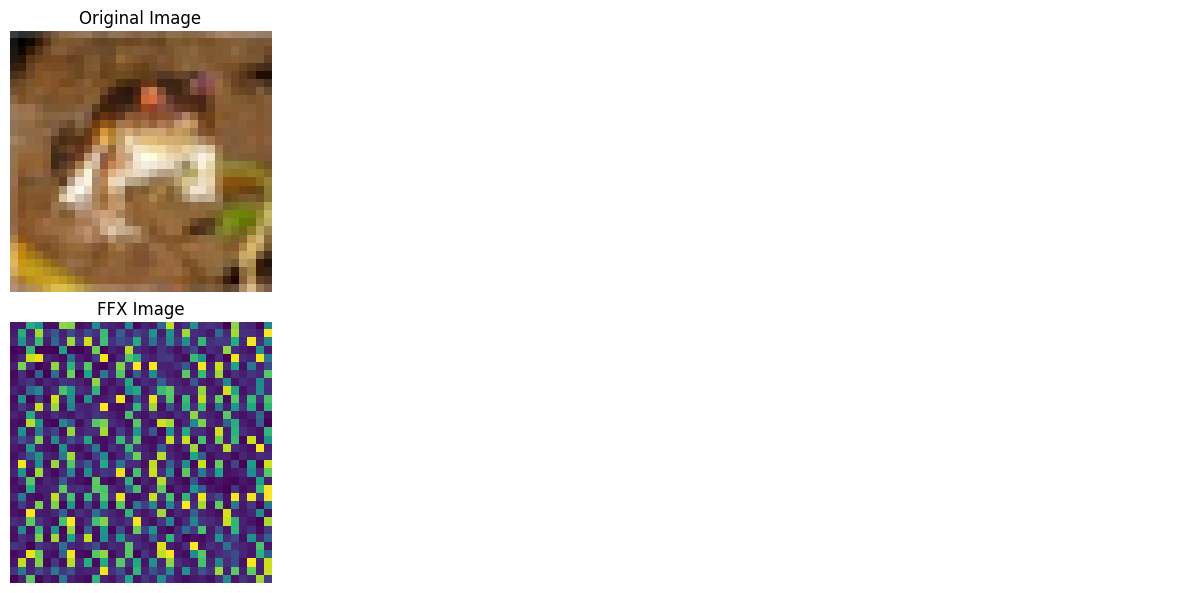

In [7]:
# 初始化配置
config = Config()

# 加载CIFAR-10数据集
transform = transforms.Compose([transforms.ToTensor()])
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# 获取一个样本图像
image, label = cifar10[0]
print(image.shape)
image = image.unsqueeze(0)  # 增加批次维度
print(image.shape)

# 初始化转换类
ffx_transform = FFX(config)

# 可视化原图像及变换后的图像
fig, axs = plt.subplots(2, 4, figsize=(12, 6))

axs[0, 0].imshow(image[0].permute(1, 2, 0))
axs[0, 0].set_title('Original Image')

# 应用FFX变换
ffx_image = ffx_transform(image)
# recovered_ffx_image = ffx_transform(ffx_image, decrypt=True)

axs[1, 0].imshow(ffx_image[0].permute(1, 2, 0))
axs[1, 0].set_title('FFX Image')
# axs[1, 1].imshow(recovered_ffx_image[0].permute(1, 2, 0))
# axs[1, 1].set_title('Recovered FFX Image')

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()